In [1]:
import torch
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path
import numpy as np
from nerfstudio.viewer.viewer import Viewer
from nerfstudio.configs.base_config import ViewerConfig
# config = Path("outputs/garfield_plushie/dig/2024-02-27_144117/config.yml")#pca 64
# config = Path("outputs/garfield_plushie/dig/2024-02-27_163355/config.yml")#pca 128
# config = Path("outputs/garfield_plushie/dig/2024-02-27_164651/config.yml")#v2 128 dim
# config = Path("outputs/garfield_plushie/dig/2024-02-27_170339/config.yml")##v2 128 dim, 7stride
# config = Path("outputs/garfield_plushie/dig/2024-02-28_180544/config.yml")#v2, 64 dim 7 stride
#all above s model
# config = Path("outputs/garfield_plushie/dig/2024-02-29_133302/config.yml")#v2, b model, 64 dim 7 stride
# config = Path("outputs/garfield_plushie/dig/2024-02-29_135125/config.yml")#v2, b model, 64 dim 14 stride
# config = Path("outputs/garfield_plushie/dig/2024-02-29_142826/config.yml")#v2, b model, 64 dim 14 stride, huber loss
# config = Path("outputs/louvre_statue/dig/2024-02-29_144220/config.yml")#v2, b model, 64 dim 14 stride, huber loss

#original pipeline
# config = Path("outputs/garfield_static/dig/2024-03-05_190847/config.yml")
#denoised pipeline
# config = Path("outputs/garfield_static/dig/2024-03-05_185418/config.yml")

#original with config file change
# config = Path("outputs/garfield_static/dig/2024-03-06_145516/config.yml")
#denoised with config file change
config = Path("outputs/garfield_static/dig/2024-03-06_133418/config.yml")
_,pipeline,_,_ = eval_setup(config)
dino_loader = pipeline.datamanager.dino_dataloader
if hasattr(pipeline,"garfield_pipeline"):
    v = Viewer(ViewerConfig(default_composite_depth=False),config.parent,pipeline.datamanager.get_datapath(),pipeline)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


[15:58:40] Auto image downscale factor of 2                                                 ]8;id=570131;file:///home/mingxuan/projects/nerf/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=84532;file:///home/mingxuan/projects/nerf/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

           Caching / undistorting train images                                            ]8;id=538651;file:///home/mingxuan/projects/nerf/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=487805;file:///home/mingxuan/projects/nerf/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#182\182]8;;\

Output()

[15:58:44] Caching / undistorting eval images                                             ]8;id=480847;file:///home/mingxuan/projects/nerf/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=291346;file:///home/mingxuan/projects/nerf/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#196\196]8;;\

Output()

Using cache found in /home/mingxuan/.cache/torch/hub/facebookresearch_dinov2_main
/home/mingxuan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/mingxuan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/mingxuan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Dino data shape torch.Size([356, 33, 60, 64])


Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/garfield_static/dig/2024-03-06_133418/nerfstudio_models/step-000008000.ckpt

denoiser.norm1.weight loaded
denoiser.norm1.bias loaded
denoiser.attn.qkv.weight loaded
denoiser.attn.qkv.bias loaded
denoiser.attn.proj.weight loaded
denoiser.attn.proj.bias loaded
denoiser.norm2.weight loaded
denoiser.norm2.bias loaded
denoiser.mlp.fc1.weight loaded
denoiser.mlp.fc1.bias loaded
denoiser.mlp.fc2.weight loaded
denoiser.mlp.fc2.bias loaded


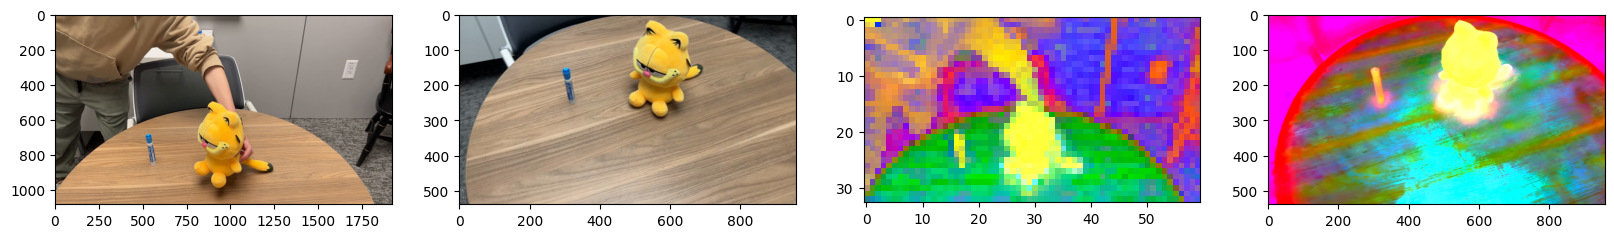

In [2]:
from PIL import Image
from torchvision.transforms import ToTensor
import moviepy.editor as mpy
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly
plotly.offline.init_notebook_mode()
video_path = Path("../datasets/video/garfield_move.mp4")
clip = mpy.VideoFileClip(str(video_path))
#print length of video in seconds
frame = clip.get_frame(6.5)
pil_image = ToTensor()(Image.fromarray(frame))

# image_path = Path("/home/justin/nerfstudio/data/colorful_mugs_colmap/images/frame_00010.jpg")
# image_path = Path("../datasets/data/garfield_static/images/frame_00170.png")
# pil_image = ToTensor()(Image.open(image_path))
img_pca_feats = dino_loader.get_pca_feats(pil_image.unsqueeze(0)).cuda().squeeze()
cam,data = pipeline.datamanager.next_train(0)
outputs = pipeline.model.get_outputs_for_camera(cam)
outputs['dino'][outputs['dino_alpha']<.9] = 0
which_to_rgb_pca = torch.cat([outputs['dino'].view(-1,img_pca_feats.shape[-1]),img_pca_feats.view(-1,img_pca_feats.shape[-1])],dim=0)
# which_to_rgb_pca = outputs['dino'].view(-1,img_pca_feats.shape[-1])
_,_,rgb_pca = torch.pca_lowrank(which_to_rgb_pca.view(-1,which_to_rgb_pca.shape[-1]), q=3, niter=30)
from nerfstudio.utils.colormaps import apply_pca_colormap
_,axs = plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(pil_image.permute(1,2,0).cpu().numpy())
axs[1].imshow(data["image"].cpu().numpy())
axs[2].imshow(apply_pca_colormap(img_pca_feats,rgb_pca).cpu().numpy())
axs[3].imshow(apply_pca_colormap(outputs["dino"],rgb_pca).cpu().numpy())
# axs[2].imshow(apply_pca_colormap(img_pca_feats).cpu().numpy())
# axs[3].imshow(apply_pca_colormap(outputs["dino"]).cpu().numpy())
plt.show()
#same thing but with plotly
# fig = make_subplots(rows=1, cols=4)
# # Add images to each subplot
# fig.add_trace(go.Image(z=pil_image.permute(1, 2, 0).cpu().numpy()*255), row=1, col=1)
# fig.add_trace(go.Image(z=data["image"].cpu().numpy()*255), row=1, col=2)
# fig.add_trace(go.Image(z=apply_pca_colormap(img_pca_feats, rgb_pca).cpu().numpy()*255), row=1, col=3)
# fig.add_trace(go.Image(z=apply_pca_colormap(outputs["dino"], rgb_pca).cpu().numpy()*255), row=1, col=4)
# fig.update_layout(width=1500) 

33.11314010620117 12.466915130615234
25.737043380737305 6.879970550537109
23.528610229492188 6.861083507537842
22.415512084960938 8.46794605255127
25.973358154296875 7.225390434265137
23.948894500732422 8.214958190917969
25.8848819732666 8.402937889099121
28.251850128173828 8.681867599487305
31.621925354003906 6.507744789123535
28.460294723510742 7.303183078765869
30.076934814453125 5.148979187011719
27.591611862182617 5.221927165985107
28.76673698425293 9.829384803771973
29.71294403076172 10.902894020080566
28.44977378845215 9.627896308898926
26.918588638305664 8.070257186889648
27.201278686523438 6.146661281585693
26.66758918762207 5.704894542694092
23.234878540039062 6.860291481018066
31.030757904052734 5.629891872406006
30.11347770690918 5.27480936050415
31.33149528503418 4.970154285430908
27.405256271362305 7.552963733673096
26.372638702392578 7.845367908477783
29.36037826538086 5.253161907196045
27.729412078857422 5.961423397064209
29.217695236206055 5.072497367858887
28.10773849

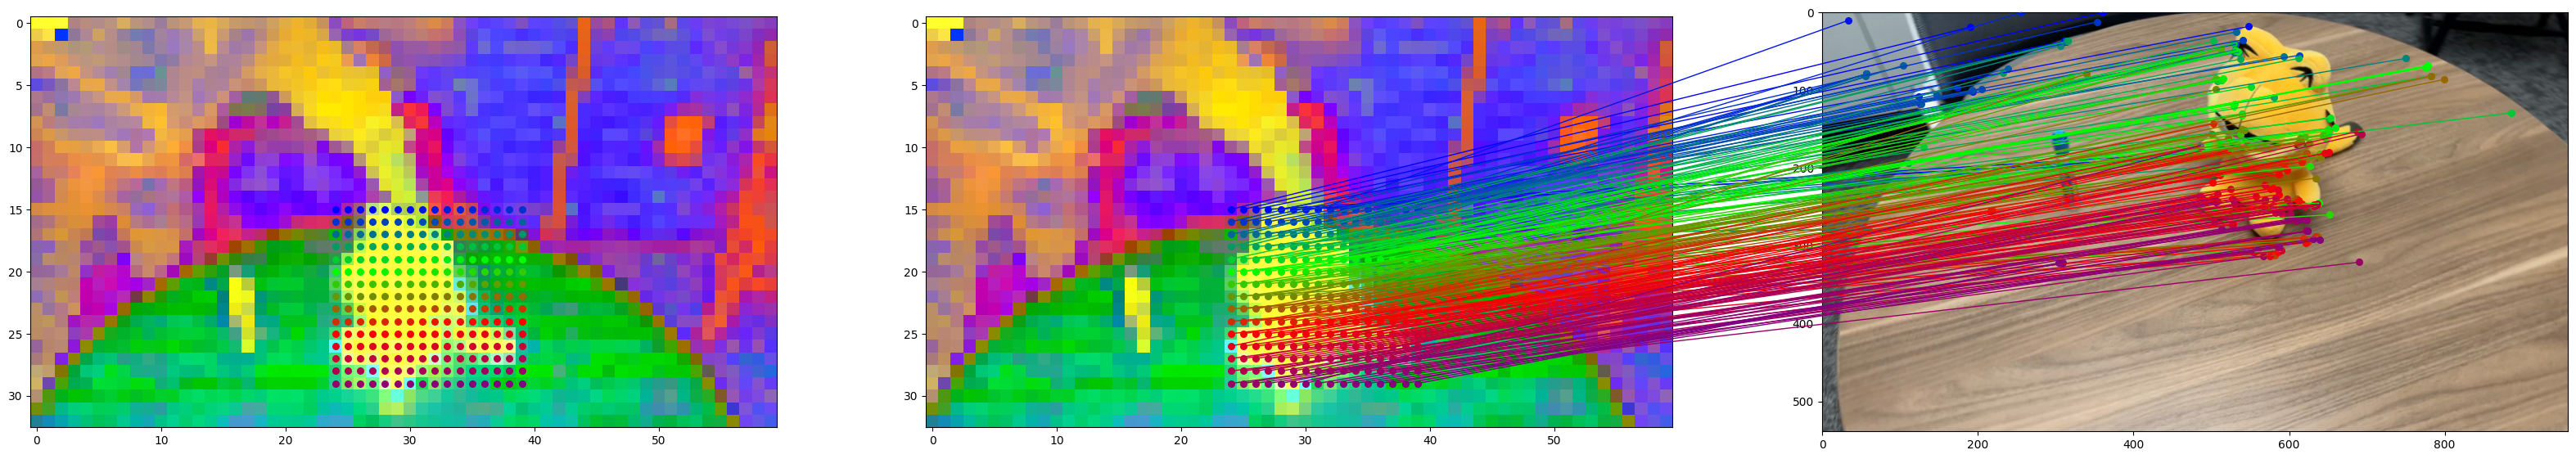

In [3]:
from matplotlib.patches import ConnectionPatch



# pix_coords = [(20,30),(26,37),(28,30),(21,16)]
#place pixe_coords with 10*10 grid of points(not randome) and find the closest match in the dino image
pix_coords = [(i,j) for i in range(15,30) for j in range(24,40)]
# pix_coords = [(np.random.randint(15,30),np.random.randint(20,40)) for _ in range(40)]
pix_matches = []
# _,diff_axs = plt.subplots(2,len(pix_coords),figsize=(20,10))
for i,pc in enumerate(pix_coords):
    img_pca_feat = img_pca_feats[pc[0],pc[1],:]
    distance_img = (outputs['dino'] - img_pca_feat).pow(2).sum(dim=-1).sqrt()[...,None]
    img_distance = (img_pca_feats - img_pca_feat).pow(2).sum(dim=-1).sqrt()
    # print(img_distance.max().item(),img_distance.min().item())
    # print(distance_img.max().item(),distance_img.min().item())
    # diff_axs[0,i].imshow(distance_img.cpu().numpy().squeeze(),vmin=10,vmax=30)
    # diff_axs[1,i].imshow(img_distance.cpu().numpy(),vmin=10,vmax=30)
    print(img_distance.max().item(),distance_img.min().item())
    # diff_axs[0,i].imshow(distance_img.cpu().numpy().squeeze())
    # diff_axs[1,i].imshow(img_distance.cpu().numpy())
    argmin = torch.argmin(distance_img).cpu().numpy()
    argmin_coords = (argmin//distance_img.shape[1],argmin%distance_img.shape[1])
    pix_matches.append(argmin_coords)
    
fig,axs = plt.subplots(1,3,figsize=(40,20))
#visualize the input click on the original image
axs[0].imshow(apply_pca_colormap(img_pca_feats,rgb_pca).cpu().numpy())
axs[1].imshow(apply_pca_colormap(img_pca_feats,rgb_pca).cpu().numpy())
# axs[2].imshow(apply_pca_colormap(outputs["dino"],rgb_pca).cpu().numpy())
# axs[0].imshow(apply_pca_colormap(img_pca_feats).cpu().numpy())
axs[2].imshow(data["image"].cpu().numpy())

#colors  gradient ramp for color of the pixel

num_steps = len(pix_matches)
# Define four key colors for the gradient
colors = [
    np.array([0, 0, 255]),  # Blue
    np.array([0, 255, 0]),  # Green
    np.array([255, 0, 0]),  # Red
    np.array([128, 0, 128])  # Purple
]

# Calculate steps per transition considering three transitions over 400 steps
steps_per_transition = num_steps // (len(colors) - 1)

# Initialize the gradient ramp
complex_gradient_ramp = np.zeros((num_steps, 3), dtype=int)

# Generate the gradient by interpolating between each pair of colors
current_step = 0
for i in range(len(colors) - 1):
    start_color = colors[i]
    end_color = colors[i + 1]
    for j in range(3):  # Iterate over the color channels
        # Calculate the end step for the current transition
        end_step = current_step + steps_per_transition
        if i == len(colors) - 2:  # Ensure we fill to the end for the last transition
            end_step = num_steps
        # Interpolate the current color channel from start_color to end_color
        complex_gradient_ramp[current_step:end_step, j] = np.linspace(start_color[j], end_color[j], end_step - current_step).astype(int)
    current_step += steps_per_transition

complex_gradient_ramp =  complex_gradient_ramp / 255  # Normalize to [0, 1]

for i in range(len(pix_matches)):
    # color = np.random.rand(3)
    color = complex_gradient_ramp[i]
    transFigure = fig.transFigure.inverted()
    con = ConnectionPatch(xyA=(pix_coords[i][1],pix_coords[i][0]), xyB=(pix_matches[i][1],pix_matches[i][0]),
                           coordsA="data", coordsB="data",
                      axesA=axs[1], axesB=axs[2], color=color)
    fig.add_artist(con)
    axs[0].scatter(pix_coords[i][1],pix_coords[i][0],c=color,s=30)
    axs[1].scatter(pix_coords[i][1],pix_coords[i][0],c=color,s=30)
    axs[2].scatter(pix_matches[i][1],pix_matches[i][0],c=color,s=30)
plt.show()

33.11314010620117 12.466915130615234
25.737043380737305 6.879970550537109
23.528610229492188 6.861083507537842
22.415512084960938 8.46794605255127
25.973358154296875 7.225390434265137
23.948894500732422 8.214958190917969
25.8848819732666 8.402937889099121
28.251850128173828 8.681867599487305
31.621925354003906 6.507744789123535
28.460294723510742 7.303183078765869
30.076934814453125 5.148979187011719
27.591611862182617 5.221927165985107
28.76673698425293 9.829384803771973
29.71294403076172 10.902894020080566
28.44977378845215 9.627896308898926
26.918588638305664 8.070257186889648
27.201278686523438 6.146661281585693
26.66758918762207 5.704894542694092
23.234878540039062 6.860291481018066
31.030757904052734 5.629891872406006
30.11347770690918 5.27480936050415
31.33149528503418 4.970154285430908
27.405256271362305 7.552963733673096
26.372638702392578 7.845367908477783
29.36037826538086 5.253161907196045
27.729412078857422 5.961423397064209
29.217695236206055 5.072497367858887
28.10773849

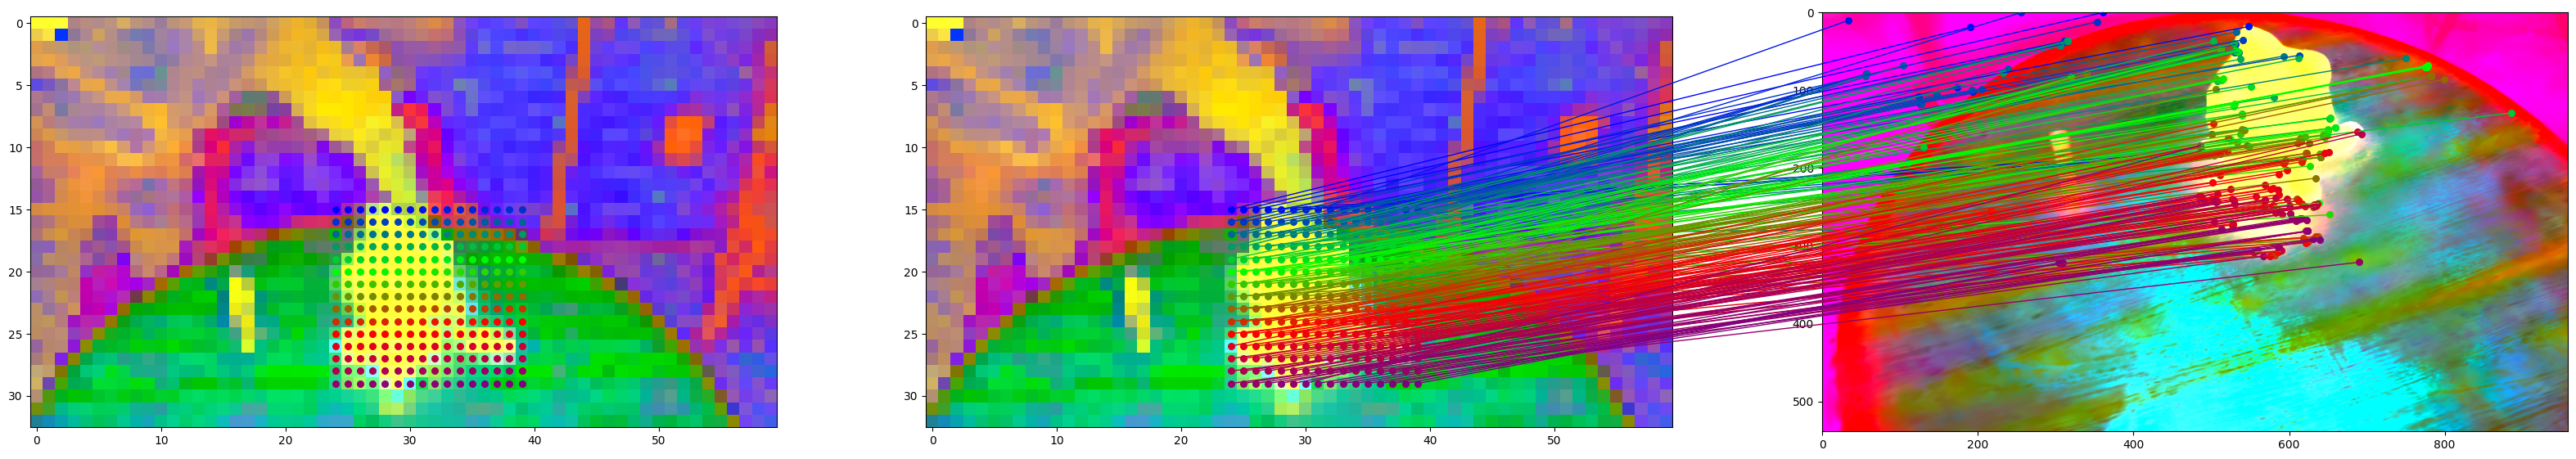

In [4]:
from matplotlib.patches import ConnectionPatch



# pix_coords = [(20,30),(26,37),(28,30),(21,16)]
#place pixe_coords with 10*10 grid of points(not randome) and find the closest match in the dino image
pix_coords = [(i,j) for i in range(15,30) for j in range(24,40)]
# pix_coords = [(np.random.randint(15,30),np.random.randint(20,40)) for _ in range(40)]
pix_matches = []
# _,diff_axs = plt.subplots(2,len(pix_coords),figsize=(20,10))
for i,pc in enumerate(pix_coords):
    img_pca_feat = img_pca_feats[pc[0],pc[1],:]
    distance_img = (outputs['dino'] - img_pca_feat).pow(2).sum(dim=-1).sqrt()[...,None]
    img_distance = (img_pca_feats - img_pca_feat).pow(2).sum(dim=-1).sqrt()
    # print(img_distance.max().item(),img_distance.min().item())
    # print(distance_img.max().item(),distance_img.min().item())
    # diff_axs[0,i].imshow(distance_img.cpu().numpy().squeeze(),vmin=10,vmax=30)
    # diff_axs[1,i].imshow(img_distance.cpu().numpy(),vmin=10,vmax=30)
    print(img_distance.max().item(),distance_img.min().item())
    # diff_axs[0,i].imshow(distance_img.cpu().numpy().squeeze())
    # diff_axs[1,i].imshow(img_distance.cpu().numpy())
    argmin = torch.argmin(distance_img).cpu().numpy()
    argmin_coords = (argmin//distance_img.shape[1],argmin%distance_img.shape[1])
    pix_matches.append(argmin_coords)
    
fig,axs = plt.subplots(1,3,figsize=(40,20))
#visualize the input click on the original image
axs[0].imshow(apply_pca_colormap(img_pca_feats,rgb_pca).cpu().numpy())
axs[1].imshow(apply_pca_colormap(img_pca_feats,rgb_pca).cpu().numpy())
axs[2].imshow(apply_pca_colormap(outputs["dino"],rgb_pca).cpu().numpy())
# axs[0].imshow(apply_pca_colormap(img_pca_feats).cpu().numpy())
# axs[2].imshow(data["image"].cpu().numpy())

#colors  gradient ramp for color of the pixel

num_steps = len(pix_matches)
# Define four key colors for the gradient
colors = [
    np.array([0, 0, 255]),  # Blue
    np.array([0, 255, 0]),  # Green
    np.array([255, 0, 0]),  # Red
    np.array([128, 0, 128])  # Purple
]

# Calculate steps per transition considering three transitions over 400 steps
steps_per_transition = num_steps // (len(colors) - 1)

# Initialize the gradient ramp
complex_gradient_ramp = np.zeros((num_steps, 3), dtype=int)

# Generate the gradient by interpolating between each pair of colors
current_step = 0
for i in range(len(colors) - 1):
    start_color = colors[i]
    end_color = colors[i + 1]
    for j in range(3):  # Iterate over the color channels
        # Calculate the end step for the current transition
        end_step = current_step + steps_per_transition
        if i == len(colors) - 2:  # Ensure we fill to the end for the last transition
            end_step = num_steps
        # Interpolate the current color channel from start_color to end_color
        complex_gradient_ramp[current_step:end_step, j] = np.linspace(start_color[j], end_color[j], end_step - current_step).astype(int)
    current_step += steps_per_transition

complex_gradient_ramp =  complex_gradient_ramp / 255  # Normalize to [0, 1]

for i in range(len(pix_matches)):
    # color = np.random.rand(3)
    color = complex_gradient_ramp[i]
    transFigure = fig.transFigure.inverted()
    con = ConnectionPatch(xyA=(pix_coords[i][1],pix_coords[i][0]), xyB=(pix_matches[i][1],pix_matches[i][0]),
                           coordsA="data", coordsB="data",
                      axesA=axs[1], axesB=axs[2], color=color)
    fig.add_artist(con)
    axs[0].scatter(pix_coords[i][1],pix_coords[i][0],c=color,s=30)
    axs[1].scatter(pix_coords[i][1],pix_coords[i][0],c=color,s=30)
    axs[2].scatter(pix_matches[i][1],pix_matches[i][0],c=color,s=30)
plt.show()